- This is a POC to show the capability of creating a NLP model for classificaiton
- This note book including fine-tuning the language model and fine-tuning a classifier

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

import torch
from datasets import Dataset, DatasetDict
from transformers import (
    TrainingArguments, 
    Trainer,
    AutoTokenizer, 
    AutoConfig,
    AutoModelForSequenceClassification, 
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling, 
    set_seed
)

c:\Users\dong\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# config file, including the parameters that are used in the notebook
model_config = {
    'max_length': 256,
    'model_ckpt': "bert-base-uncased",
    'language_model_output': './results/tuned_language_256/',
    'classifier_model_output': './results/tuned_classifier_256/',
    'batch_size': 16,
    'language_model_epochs': 8,
    'classifier_model_epochs': 3,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Read Data
DATA_DIR = os.path.abspath('') + '/data'
df_train = pd.read_csv(DATA_DIR + '/train.tsv', sep = '\t')
df_val = pd.read_csv(DATA_DIR + '/val.tsv', sep = '\t')
df_test = pd.read_csv(DATA_DIR + '/test.tsv', sep = '\t')

In [4]:
# take a look at the datasets
print('training dataset -- {} \nevaluation dataset -- {}\ntest dataset -- {}'.format(len(df_train), len(df_val), len(df_test)))

training dataset -- 35000 
evaluation dataset -- 5000
test dataset -- 10000


In [5]:
# data column names
# 'Product': the label column, this is a single-label problem;
# 'Consumer complaint narrative': string of text, which is used to predict 'Product'
df_train.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [6]:
# the counts for different 'Product'
df_train['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    14789
Debt collection                                                                  7883
Mortgage                                                                         4261
Credit card or prepaid card                                                      3011
Checking or savings account                                                      1813
Credit reporting                                                                 1683
Student loan                                                                     1560
Name: Product, dtype: int64

In [7]:
# create a mapping between labels and a integer
label2int = {k:v for v, k in enumerate(df_train['Product'].unique().tolist())}

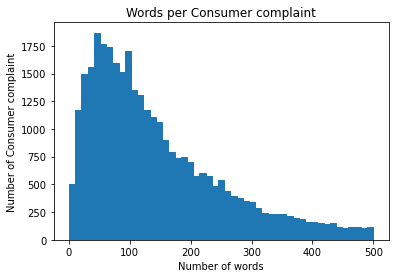

In [8]:
# a plot to show the distribution of the text length
# based on the plot, the text length set to be 256 would be a proper number
(df_train['Consumer complaint narrative'].str.split().apply(len)
 .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per Consumer complaint")
plt.xlabel("Number of words")
plt.ylabel("Number of Consumer complaint")
plt.show()

## create training sets

In [9]:
def create_dataframe(df):
    # change column names
    df.rename(columns={'Product':'label', 'Consumer complaint narrative':'text'}, inplace=True)
    # map the label to the integer
    df['label'] = df['label'].replace(label2int)
    return df

df_train = create_dataframe(df_train)
df_val = create_dataframe(df_val)
df_test = create_dataframe(df_test)

In [10]:
# create datsetdic for transformers model
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_val.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True))
    })

## fine-tuning the language model
- using mask language modeling

In [11]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_config['model_ckpt'])
# create dataset for the mask language modeling
def tokenize(batch, tokenizer=tokenizer):
    return tokenizer(batch["text"], truncation=True,
                     max_length=model_config['max_length'], 
                     return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["label", "text"])

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [12]:
# create data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15,
                                                return_tensors = "pt")

# create train args
language_tunning_training_args = TrainingArguments(
    output_dir = model_config['language_model_output'], 
    per_device_train_batch_size = model_config['batch_size'],
    disable_tqdm=False, logging_strategy="epoch", 
    evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=model_config['language_model_epochs'], 
    log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained(model_config['model_ckpt']).to(device),
        tokenizer=tokenizer, args=language_tunning_training_args, data_collator=data_collator,
        train_dataset=ds_mlm["train"], eval_dataset=ds_mlm["valid"])

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/17504 [00:00<?, ?it/s]

{'loss': 1.6616, 'learning_rate': 4.375e-05, 'epoch': 1.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 1.4505548477172852, 'eval_runtime': 103.5988, 'eval_samples_per_second': 48.263, 'eval_steps_per_second': 6.033, 'epoch': 1.0}
{'loss': 1.4582, 'learning_rate': 3.7500000000000003e-05, 'epoch': 2.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 1.3628201484680176, 'eval_runtime': 98.9671, 'eval_samples_per_second': 50.522, 'eval_steps_per_second': 6.315, 'epoch': 2.0}
{'loss': 1.3814, 'learning_rate': 3.125e-05, 'epoch': 3.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 1.313732624053955, 'eval_runtime': 102.6583, 'eval_samples_per_second': 48.705, 'eval_steps_per_second': 6.088, 'epoch': 3.0}
{'loss': 1.3229, 'learning_rate': 2.5e-05, 'epoch': 4.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 1.2686212062835693, 'eval_runtime': 96.6144, 'eval_samples_per_second': 51.752, 'eval_steps_per_second': 6.469, 'epoch': 4.0}
{'loss': 1.2767, 'learning_rate': 1.8750000000000002e-05, 'epoch': 5.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 1.250378131866455, 'eval_runtime': 102.4152, 'eval_samples_per_second': 48.821, 'eval_steps_per_second': 6.103, 'epoch': 5.0}
{'loss': 1.2396, 'learning_rate': 1.25e-05, 'epoch': 6.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 1.2216867208480835, 'eval_runtime': 66.1933, 'eval_samples_per_second': 75.536, 'eval_steps_per_second': 9.442, 'epoch': 6.0}
{'loss': 1.2144, 'learning_rate': 6.25e-06, 'epoch': 7.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 1.204223871231079, 'eval_runtime': 79.5783, 'eval_samples_per_second': 62.831, 'eval_steps_per_second': 7.854, 'epoch': 7.0}
{'loss': 1.1911, 'learning_rate': 0.0, 'epoch': 8.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 1.1981565952301025, 'eval_runtime': 98.7687, 'eval_samples_per_second': 50.623, 'eval_steps_per_second': 6.328, 'epoch': 8.0}
{'train_runtime': 12117.572, 'train_samples_per_second': 23.107, 'train_steps_per_second': 1.445, 'train_loss': 1.343237672906907, 'epoch': 8.0}


TrainOutput(global_step=17504, training_loss=1.343237672906907, metrics={'train_runtime': 12117.572, 'train_samples_per_second': 23.107, 'train_steps_per_second': 1.445, 'train_loss': 1.343237672906907, 'epoch': 8.0})

In [13]:
# save model and tokenizer
trainer.save_model(model_config['language_model_output'])
tokenizer.save_pretrained(model_config['language_model_output'])

('./results/tuned_language_256/tokenizer_config.json',
 './results/tuned_language_256/special_tokens_map.json',
 './results/tuned_language_256/vocab.txt',
 './results/tuned_language_256/added_tokens.json',
 './results/tuned_language_256/tokenizer.json')

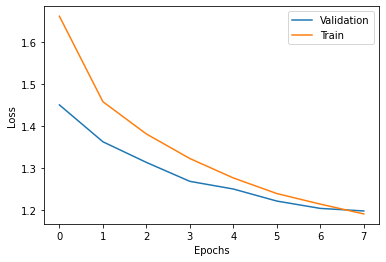

In [14]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")
 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

## Fine-Tuning a classifier

In [15]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_config['language_model_output'])

# create dataset for fine-tuning classifier model
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['text', 'special_tokens_mask'])

ds_enc.set_format("torch")

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [16]:
# load model from tuned language model output
model = (AutoModelForSequenceClassification
         .from_pretrained(model_config['language_model_output'], num_labels=len(label2int))
         .to(device))

training_args_fine_tune = TrainingArguments(
    output_dir=model_config['classifier_model_output'], 
    num_train_epochs=model_config['classifier_model_epochs'], 
    learning_rate=3e-5,
    lr_scheduler_type='constant', 
    per_device_train_batch_size=model_config['batch_size'],
    per_device_eval_batch_size=model_config['batch_size'], 
    weight_decay=0.01, 
    evaluation_strategy="epoch", save_strategy="no",logging_strategy="epoch",
    # load_best_model_at_end=True,
    disable_tqdm=False, save_total_limit=2, log_level='error')

In [17]:
# write the metrics function 
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [18]:
# create
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['text', 'special_tokens_mask'])

ds_enc.set_format("torch")

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [19]:
trainer = Trainer(model=model, args=training_args_fine_tune, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_enc["train"],
                  eval_dataset=ds_enc["valid"],
                  tokenizer=tokenizer)
trainer.train()

  0%|          | 0/6564 [00:00<?, ?it/s]

{'loss': 0.5545, 'learning_rate': 3e-05, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.5151715874671936, 'eval_accuracy': 0.8222, 'eval_f1': 0.8186776600738466, 'eval_runtime': 42.8177, 'eval_samples_per_second': 116.774, 'eval_steps_per_second': 7.31, 'epoch': 1.0}
{'loss': 0.3797, 'learning_rate': 3e-05, 'epoch': 2.0}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.4620875120162964, 'eval_accuracy': 0.8454, 'eval_f1': 0.8420448176149775, 'eval_runtime': 42.5281, 'eval_samples_per_second': 117.569, 'eval_steps_per_second': 7.36, 'epoch': 2.0}
{'loss': 0.2654, 'learning_rate': 3e-05, 'epoch': 3.0}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.5854176878929138, 'eval_accuracy': 0.835, 'eval_f1': 0.8347772828768925, 'eval_runtime': 52.3511, 'eval_samples_per_second': 95.509, 'eval_steps_per_second': 5.979, 'epoch': 3.0}
{'train_runtime': 2986.6426, 'train_samples_per_second': 35.157, 'train_steps_per_second': 2.198, 'train_loss': 0.39987842808548524, 'epoch': 3.0}


TrainOutput(global_step=6564, training_loss=0.39987842808548524, metrics={'train_runtime': 2986.6426, 'train_samples_per_second': 35.157, 'train_steps_per_second': 2.198, 'train_loss': 0.39987842808548524, 'epoch': 3.0})

In [20]:
test_results = trainer.predict(ds_enc['test'])
metrics1 = compute_metrics(test_results)
metrics1

  0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.8433, 'f1': 0.8430471788083367}

In [21]:
trainer.save_model(model_config['classifier_model_output'])
tokenizer.save_pretrained(model_config['classifier_model_output'])

('./results/tuned_classifier_256/tokenizer_config.json',
 './results/tuned_classifier_256/special_tokens_map.json',
 './results/tuned_classifier_256/vocab.txt',
 './results/tuned_classifier_256/added_tokens.json',
 './results/tuned_classifier_256/tokenizer.json')

## predict on test dataset

[test link](https://discuss.huggingface.co/t/using-trainer-at-inference-time/9378/2)

In [22]:
test_model = AutoModelForSequenceClassification.from_pretrained(model_config['classifier_model_output']).to(device)

# arguments for Trainer
test_args = TrainingArguments(
    output_dir = model_config['classifier_model_output'],
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = 1,   
    dataloader_drop_last = False    
)

# init trainer
test_trainer = Trainer(model = test_model, args = test_args, compute_metrics = compute_metrics)

test_results = test_trainer.predict(ds_enc['test'])
metrics1 = compute_metrics(test_results)
metrics1

***** Running Prediction *****
  Num examples = 10000
  Batch size = 1


{'accuracy': 0.8433, 'f1': 0.8430471788083367}